<h1>Final Code Report</h1>

<h2>Initial Setup and Server Data</h2>

In [1]:
import random
import math
import numpy as np

In [2]:
#INFO ABOUT SERVERS
power_levels = [0,50,100] #0=off 1=su 2=on-dynamic so not 1 but for simplification
M = 2000 # number of servers
processing_capacity_c_on = 1 # 1 task per time sample for simplification
task_processing_time = 1/processing_capacity_c_on # TIME TO DO 1 TASK
server_startup_time = 10 # TIME FOR SU DELAY Ts
max_capacity = M*processing_capacity_c_on
servers = [random.randint(0, 2) for _ in range(M)] # number of servers: 0=off 1=su 2=on-dynamic so not 1 but for simplification

<h2>Estimation of first point Mu and Initial server on-off state</h2>

In [3]:
#Estimation of first point mu and c
N = 2000
state_transition = {"idle": ["P00","P01","P02"], "normal": ["P10","P11","P12"], "busy": ["P20","P21","P22"]}
state_transition_probability = {"idle": [0.2,0.8,0.0], "normal": [0.1,0.8,0.1], "busy": [0.0,0.9,0.1]}
mu_est = [0,0,0]

for i in range(N):
    trans = random.choice(list(state_transition.keys()))
    change = np.random.choice(state_transition[trans],replace=True,p=state_transition_probability[trans])
    state_old = (int(change[-2:-1]))
    state_new = (int(change[-1:]))
    mu_est[state_new] +=1 
    
for i in range(len(mu_est)):
   mu_est[i] = mu_est[i]/N
print(mu_est)

[0.1065, 0.8195, 0.074]


<h2>RTO Algorithm</h2>

In [4]:
#MMPP RANDOM PROCESS Params
set_lambda = [0.3*max_capacity, 0.6*max_capacity, 0.9*max_capacity] 
transition_matrix = [[0.2,0.8,0.0],[0.1,0.8,0.1],[0.0,0.9,0.1]] #assume that servers stay most of the time in normal state
l_mean = [math.ceil(lamb) for lamb in set_lambda] 
c_mean = [math.ceil(lamb) for lamb in set_lambda]

In [5]:
#power consumption:
def power(c):
    total_power = 0
    for i in range(len(c)):
        power = c[i]*power_levels[i]
        total_power += power
    return total_power

Transition change is from idle to normal
Lambda according to the state is: 1200
Delay constraint D(u) is satisfied :1.1 <= 2
l_h = 1298  x(k) = 1180    u = 54      servers[off, start-up, on] = [764, 54, 1182]
Consumption at time slot = 0 is: 120900


Transition change is from normal to normal
Lambda according to the state is: 1200
Delay constraint D(u) is satisfied :1.0989451476793248 <= 2
l_h = 1301  x(k) = 1185    u = 57      servers[off, start-up, on] = [707, 111, 1182]
Consumption at time slot = 1 is: 123750


Transition change is from normal to normal
Lambda according to the state is: 1200
Delay constraint D(u) is satisfied :1.1008505616601538 <= 2
l_h = 1256  x(k) = 1137    u = 30      servers[off, start-up, on] = [677, 141, 1182]
Consumption at time slot = 2 is: 125250


Transition change is from normal to normal
Lambda according to the state is: 1200
Delay constraint D(u) is satisfied :1.0910033697500987 <= 2
l_h = 1278  x(k) = 1204    u = 43      servers[off, start-up, on] = [

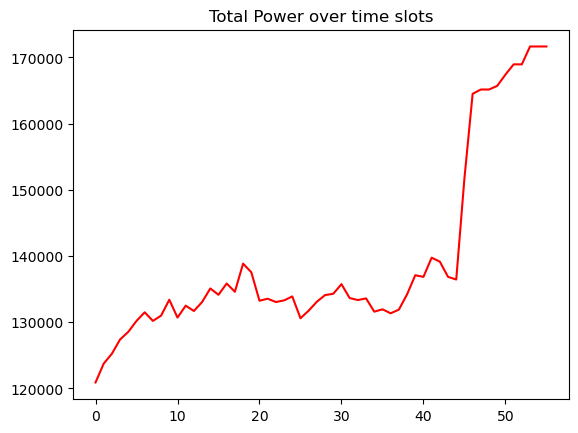

In [6]:
import matplotlib.pyplot as plt

ts = server_startup_time
a = 0.5
b = 0.6
N = 1000
c = [818,0,1182]
l_hat = 1300
mu = mu_est
TD = 2 #ALLOWABLE TIME DELAY CONSTRAINT

state_transition = {"idle": ["idle","normal","busy"], "normal": ["idle","normal","busy"], "busy": ["idle","normal","busy"]}
state_transition_probability = {"idle": [0.2,0.8,0.0], "normal": [0.1,0.8,0.1], "busy": [0.0,0.9,0.1]}

constraint = []

power_if_change = 0
counter = [0,0,0]
powers = []
trans = random.choice(list(state_transition.keys()))
remainder_tasks = 0
startups = []
for k in range(N):
    change = np.random.choice(state_transition[trans],replace=True,p=state_transition_probability[trans])
    print(f"Transition change is from {trans} to {change}")
    trans = change
    if trans == "idle":
        lam = 600
    elif trans == "normal":
        lam = 1200
    else:
        lam = 1800
    print(f"Lambda according to the state is: {lam}")
    l_mean = lam
    if startups != []:
        for startup in startups:
            if startup[0] <= 0:
                c[1] -= startup[1]
                c[2] += startup[1]
                startups.pop(startups.index(startup))
            startup[0] -= 1
    x = np.random.poisson(lam) 
    l_hat = (l_hat + remainder_tasks) + x - min(l_hat,c[2])
    c_hat = 0
    mu = np.dot(mu,transition_matrix)
    for j in range(3):
        c_hat += set_lambda[j] * mu[j]
    u = math.floor(a*(c_hat-c_mean[1])+b*(l_hat-l_mean))
    if u > 0:
        if (c[0] - u) >= 0:
            startups.append([ts,u])
            c[1] += u
            c[0] -= u
            remainder_tasks = 0
        elif (c[0] - u) < 0:
            remainder_tasks = abs(c[0]-u)
            startups.append([ts,c[0]])
            c[1] += c[0]
            c[0] -= c[0]
    elif u < 0:
        c[2] += u
        c[0] -= u

    constraint.append(l_hat/x)
    power_now = power(c)
    powers.append(power_now)
    delay = sum(constraint)/len(constraint)
    if delay > TD:
        print(f"Delay constraint D(u) is unsatisfied :{delay} > {TD} break the optimization")
        k = N-1
        break
    elif delay <= TD:
        print(f"Delay constraint D(u) is satisfied :{delay} <= {TD}")
    print(f"l_h = {l_hat}  x(k) = {x}    u = {u}      servers[off, start-up, on] = {c}")
    print(f"Consumption at time slot = {k} is: {power_now}")
    print("\n")
plt.title("Total Power over time slots")
plt.plot(range(len(powers)), powers, color="red")